# Etapas
## Etapa 1: Calcular a probabilidade de pessoas sem diagnóstico terem a doença dado que elas pertencem a um determinado cluster
### Método elbow 
* Definir a quantidade ótima de clusters para o nosso conjunto de dados
* O PCA foi utilizado para diminuir a dimensão do espaço das fetures de 8 para 2. Dessa forma,  o método definirá a quantidade ideal de cluster em um espaço de duas dimensões.
* O PCA foi utilizado para obter uma representação melhor dos clusters no gráfico de duas dimensões
* A eficiência na divisão dos clusters é pouco afetada porque PCA mantém a essência dos dados originais

### Clusterização
* Realizar a clusterização utilizando o MinibatchKmean
* A quantidade de clusters será a definida pelo método elbow
* O PCA foi utilizado novamente para diminuir o espaço das features de 8 para 2. Portanto, a clusterização será baseada nas duas features geradas pelo PCA (pca1 e pca2).
* Não há problema implementar a clusterização dessa forma pois o PCA mantém o máximo possível da essência (diferenças entre as amostras) dos dados originais
#### Análise da clusterização
* É impresso uma análise das features mais frequentes e do percentual de pessoas com e sem diagnóstico em cada cluster
* Além disso é gerado um dataframe com as features mais frequentes em cada cluster. As linhas representam os clusters e as colunas as features.

### Divisão dos conjuntos de treino, validação e teste
* Gera um dataframe para cada um dos clusters
* Inicialmente, cada Dataframe possui as pessoas de um determinadado cluster e as features de cada uma delas
* Em seguida cada Dataframe será filtrado para obter outro Dataframe somente com as pessoas que não tem o diagnóstico
* Dessa forma, teremos cinco (número de clusters) dataframes após a filtragem:

    - O dataframe 1 contém pessoas que não possuem diagnóstico dentro do cluster 1
    - O dataframe 2 contém pessoas que não possuem diagnóstico dentro do cluster 2
    - O dataframe 3 contém pessoas que não possuem diagnóstico dentro do cluster 3
    - O dataframe 4 contém pessoas que não possuem diagnóstico dentro do cluster 4
    - O dataframe 5 contém pessoas que não possuem diagnóstico dentro do cluster 5

### Aplicação do modelo de Regressão Logística    
* Os cinco dataframes acima que são compostos somente por pessoas sem diagnóstico serão utilizados como conjunto de teste no modelo de Regressão logística. O funcionamento ocorrerá da seguinte maneira:
    - Para o teste 1, o modelo 1 será treinado e validado com todo o dataset menos as amostras do dataframe 1
    - Para o teste 2, o modelo 2 será treinado e validado com todo o dataset menos as amostras do dataframe 2
    - Para o teste 3, o modelo 3 será treinado e validado com todo o dataset menos as amostras do dataframe 3
    - Para o teste 4, o modelo 4 será treinado e validado com todo o dataset menos as amostras do dataframe 4
    - Para o teste 5, o modelo 5 será treinado e validado com todo o dataset menos as amostras do dataframe 5

#### Treinamento e Validação
* Serão treinados e validados cinco modelos de regressão logística. A validação terá as seguintes informações:
    - Média da AU-ROC
    - Média da acurácia
    - Média do F1-score

#### Aplicação do Relief em cada modelo
* O relief define quais features estão mais relacionadas com os labels (status do paciente)
* Foi gerada uma classificação das features para cada um dos modelos.

### Cálculo da probabilidade de ter a doença nos conjuntos de teste
* Cálculo da probabilidade das pessoas sem diagnóstico dos conjuntos de teste terem a doença
* O funcionamento ocorre da seguinte maneira:
    - O modelo 1 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 1 (pessoas sem diagnóstico e que pertencem ao cluster 1)
    - O modelo 2 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 2 (pessoas sem diagnóstico e que pertencem ao cluster 2)
    - O modelo 3 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 3 (pessoas sem diagnóstico e que pertencem ao cluster 3)
    - O modelo 4 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 4 (pessoas sem diagnóstico e que pertencem ao cluster 4)
    - O modelo 5 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 5 (pessoas sem diagnóstico e que pertencem ao cluster 5)        

    Ao final é gerado um gráfico que mostra a distribuição de probabilidade das pessoas sem diagnóstico terem a doença  dado que elas pertencem a um determinado cluster

## Etapa 2: Calcular a probabilidade de um novo paciente pertencer a um determinado cluster
### Selecionar uma pessoa do grupo de maior risco
* Selecionar uma amostra aleatória do grupo de maior risco
* Essa amostra será utilizada como teste. Ou seja, é esperado que o novo modelo gerado consiga prever que essa amostra pertence ao grupo de maior risco
### Modelo de regressão logística
* Nessa etapa também foi utilizado um modelo de regressão logística
* A diferença está nos rótulos que o modelo receberá. Nessa caso, os rótulos serão os clusters a qual cada amostra pertence
* Portanto, utilizando as mesmas features o modelo será treinado para prever a qual cluster cada amostra pertence
#### Treino e Validação
* A pessoa selecionada do grupo de maior risco deve ser retirada dos conjuntos de treino e validação do modelo já que será utiliazado no final do processo para fins de teste
* Divisão 80/20 para os conjuntos de treino e validação
#### Teste
* Ao final o modelo é testado utilizando a amostra pertencente ao grupo de maior risco
* O modelo prevê a probabilidade da amostra pertencer a cada um dos clusters


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from numpy import unique
from numpy import where
import statistics
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from random import seed

%matplotlib inline

# import category_encoders as ce
# import sweetviz as sv
# import dtale
# from ydata_profiling import ProfileReport

from scipy.stats import chisquare
from scipy.stats import chi2_contingency
# import pingouin as pg

#conda install numpy seaborn matplotlib scikit-learn scipy -y
#conda install -c conda-forge imbalanced-learn -y
#conda install -c conda-forge pandas-profiling -y
#conda install dtale -c conda-forge -y
#pip install Flask -U --user
#pip install sweetviz
#conda install -c conda-forge pingouin
#conda install ipympl -c conda-forge

In [2]:
seed(1)

In [3]:
# __Conexão com o dataset em CSV
# df_tuberculosis = pd.read_csv('dataset_paciente_atualizado.csv', sep=';')
# df_tuberculosis = pd.read_csv('maindb.csv', encoding="utf-8", sep = ';')
dataset_path = '../Dataset/datasetTB4.csv'
df_tuberculosis = pd.read_csv(dataset_path, sep=';')

In [4]:
df_tuberculosis = df_tuberculosis.drop('racaCor', axis=1)
df_tuberculosis

,faixaEtaria,sexo,ESCOLARID,TIPOCUP,sitAtual,tipoCaso,FORMACLIN1,classif,descoberta,bac,...,MENTAL,DROGADICAO,TABAGISMO,motMudEsquema,tipoTrat,idade,HISTOPATOL,resistencia,Status_Paciente,Status_Resistencia
0,20_29,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,Pos,...,N,N,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,1
1,40_49,M,De 4 a 7 anos,Desempregado,Cura,Novo,Pul,P+E,Demanda Ambulatorial,Pos,...,N,N,S,NaN,Supervisionado,40_54,N/realiz,SENS,Sem troca,1
2,40_49,M,De 8 a 11 anos,Outra,Cura,Novo,Pul,P+E,Elucidacao Diagn. em Internacao,N/realiz,...,N,N,N,NaN,Auto-Administrado,40_54,BAAR pos,SENS,Sem troca,1
3,50_59,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,P+E,Demanda Ambulatorial,Pos,...,N,N,N,NaN,Supervisionado,Mais de 54,N/realiz,SENS,Sem troca,1
4,30_39,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,P+E,Urgencia / Emergencia,Pos,...,N,S,N,NaN,Supervisionado,23_39,Sugestivo TB,NaN,Sem troca,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,50_59,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Demanda Ambulatorial,Pos,...,N,N,N,NaN,Supervisionado,Mais de 54,N/realiz,SENS,Sem troca,1
1532,01_04,M,Nenhuma,Outra,Cura,Novo,Meningea,Ext,Urgencia / Emergencia,Neg,...,N,N,N,NaN,Auto-Administrado,0_22,Sugestivo TB,NaN,Sem troca,0
1533,30_39,M,De 8 a 11 anos,Outra,Cura,Recidiva,Pul,Pul,Elucidacao Diagn. em Internacao,Pos,...,N,N,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,0
1534,30_39,M,De 1 a 3 anos,Desempregado,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,Pos,...,N,S,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,1


In [5]:
try:
    df_tuberculosis = df_tuberculosis.drop('testesensibilidade', axis=1)
except:
    pass

In [6]:
# Exclui a primeira coluna do dataframe
# O dataset está com a primeira coluna sem nome. Os valores representam o índice na excel
# Não precisamos dessa coluna
try:
    if df_tuberculosis.columns[0] == "Unnamed: 0":
        df_tuberculosis = df_tuberculosis.iloc[:, 1:]  # Exclui a primeira coluna do dataframe
except IndexError:
    pass

In [7]:
df_tuberculosis.head(3)

,faixaEtaria,sexo,ESCOLARID,TIPOCUP,sitAtual,tipoCaso,FORMACLIN1,classif,descoberta,bac,...,MENTAL,DROGADICAO,TABAGISMO,motMudEsquema,tipoTrat,idade,HISTOPATOL,resistencia,Status_Paciente,Status_Resistencia
0,20_29,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,Pos,...,N,N,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,1
1,40_49,M,De 4 a 7 anos,Desempregado,Cura,Novo,Pul,P+E,Demanda Ambulatorial,Pos,...,N,N,S,NaN,Supervisionado,40_54,N/realiz,SENS,Sem troca,1
2,40_49,M,De 8 a 11 anos,Outra,Cura,Novo,Pul,P+E,Elucidacao Diagn. em Internacao,N/realiz,...,N,N,N,NaN,Auto-Administrado,40_54,BAAR pos,SENS,Sem troca,1


In [8]:
try:
    df_tuberculosis = df_tuberculosis.drop(['Status_Paciente', 'resistencia'], axis=1)
except:
    pass

In [9]:
# # Analisa os dados utlizando o pandas profiling
# report = ProfileReport(df_tuberculosis,  minimal=True, title='Tuberculosis Analysis')

In [10]:
# # Salva o arquivo html com as análises realizadas pelo pandas profiling
# report.to_file("../EDA/tuberculosis_analysis.html")

In [11]:
# Gestante tem que ser retirada.
# ESCOLAR está correto? Não deveria ser o grau de escolaridade? 
# codTratAnt, o que significa? Os valores são inteiros de 1 a 9, porém, 91% são do tipo 1, ou seja, está desbalanceada.
# tratouha é 98% do tipo 0. Está desbalanceada. Não podemos usar.
# FORMACLIN2 está com 91% de valores nulos. Não vamos usar.
# FORMACLIN3 está com 99% de valores nulos. Não vamos usar.
# RXOUTRO está com muitos valores nulos e desbalanceada. Não sabemos acrescenta muito na análise. Não vamos usar.
# NECROP é 99% do tipo N/realiz. Ou seja, está desbalanceada e não comtribui para a análise. Não vamos usar.
# COMUNICEXA possui valores de 0 a 9 mas, 43.2% são igual a 0. Não vamos usar.
# COMUNICDOE possui valores de 0 a 9 mas, 43.2% são igual a 0. Não vamos usar.
# instTrat é uma variável sobre a instituição de tratamento. Não vamos usar.
# esqAtual está com 51% de valores nulos e 40% de valores iguais a OUTROS. Não vamos usar.
# nDosesPri desbalanceada e com valores nulos
# nDosesSeg desbalanceada e com valores nulos
# mtvInter1 66% de valores nulos
# OUTRAIMUNO está desbalanceada com 98% dos valores igual a N.
# resistencia 78% são valores nulos

In [12]:
# Alerta
# CULOUTRO está com muitos valores nulos e desbalanceada. Não sabemos acrescenta muito na análise.
# BACOUTRO está com muitos valores nulos e desbalanceada. Não sabemos acrescenta muito na análise.
# testesensibilidade 88% são valores nulos
# HISTOPATOL está com 16% de valores nulos e desbalanceada com 70% do tipo N/realiz.
# mtvInter1 é importante mas está com 66% de valores nulos

In [13]:
# # Mostra a análise realizada pelo d-tale
# analize_dtale

In [14]:
# # Realiza a analise do dataset utlizando a biblioteca sweetviz
# analyze_report = sv.analyze(df_tuberculosis)

In [15]:
# # Abre o arquivo html no navegador com as análises que foram realizadas pelo swetviz
# analyze_report.show_html('analize.html')

* Remove o mdEsquema e motMudEsquema pois são variáveis redundantes em relação ao status do paciente

In [16]:
# df_tuberculosis = df_tuberculosis.drop(['mdEsquema', 'motMudEsquema' ], axis=1)

## Qui-quadrado

* Qui-quadrado

In [17]:
# # Calculo do qui-quadrado em relação à variável de status do paciente

# # Armazena os valores de qui-quadrado e valor de p
# all_pvalue = pd.DataFrame()

# # Pandas index com os nomes das colunas
# feature_names = df_tuberculosis.columns
# # Converte para lista
# feature_names = list(feature_names)
# # Exclui a coluna de Status de paciente e os tipos de pacientes
# feature_names.remove('Status_Resistencia')

# # Realiza qui-quadrado para cara feature
# for i in feature_names:
#     # Cria um dataframe com duas colunas: feature i e Status_Resistencia
#     df_chisquare = df_tuberculosis.loc[:,[i, 'Status_Resistencia']].dropna()

#     df_chisquare = df_chisquare.query(f'{i} not in ["Não Preenchido", "Duvidosa"]')

#     # # Obtem somente as amostras significativas, ou seja, exclui amostras como "Não realizado", "Duvidosa", etc.
#     # if i in ["GRAU_DE_INCAPACIDADE_FISICA"]:
#     #     df_chisquare = df_chisquare.query(f'{i}=="0" or {i}=="1"')

#     # # Obtem somente as amostras significativas, ou seja, exclui amostras como "Não realizado", "Duvidosa", etc.
#     # if i == "BACILOSCOPIA":
#     #     df_chisquare = df_chisquare.query(f'{i}=="Positiva" or {i}=="Negativa"')

#     # # Obtem somente as amostras significativas
#     # if i == "GRAU_ESCOLAR":
#     #     df_chisquare = df_chisquare.query(f'{i}=="Ensino Fundamental" or {i}=="Ensino Médio" or {i}=="Ensino Superior"')

#     # # Obtem somente as amostras significativas
#     # if i == "CONTATO_PERIODO":
#     #     df_chisquare = df_chisquare.query(f'{i}=="Mais que dez anos" or {i}=="Entre cinco a dez anos" or {i}=="Entre dois a cinco anos" or {i}=="Mais que um ano" or {i}=="Entre um a dois anos"')
    
#     # Cria a tabela de contingência
#     contingency_table = pd.crosstab(df_chisquare[i], df_chisquare['Status_Resistencia'])
    
#     # Calcula o qui-quadrado
#     expected, observed, stats = pg.chi2_independence(df_chisquare, x=i, y='Status_Resistencia')
#     # Adiciona o nome da feature no dataset com os valores do qui-quadrado para fins de identificação
#     stats['Feature'] = i
    
#     # Seleciona apenas o qui-quadrado de pearson 
#     stats = stats.query('test=="pearson"')

#     # Adiciona ao dataframe com o qui-quadrado de todas as features
#     all_pvalue = pd.concat([stats, all_pvalue])

In [18]:
# # Mostra somente as features com valores de p<0.05 
# all_pvalue.query('pval<=0.05').sort_values(by='pval', ascending=False)

## One-hot Encode

In [19]:
# Transformando variáveis categoricas em númericas
df_dummy = pd.get_dummies(df_tuberculosis)

In [20]:
df_dummy.head(3)

,Status_Resistencia,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,faixaEtaria_20_29,faixaEtaria_30_39,faixaEtaria_40_49,faixaEtaria_50_59,faixaEtaria_60_69,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1,False,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
1,1,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
2,1,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,True,False,False


* Retira as colunas dos valores não preenchidos

In [21]:
# Substituir NaN por 0
df_tuberculosis.fillna('Nulo', inplace=True)
df_tuberculosis.head(3)

,faixaEtaria,sexo,ESCOLARID,TIPOCUP,sitAtual,tipoCaso,FORMACLIN1,classif,descoberta,bac,...,DIABETES,ALCOOLISMO,MENTAL,DROGADICAO,TABAGISMO,motMudEsquema,tipoTrat,idade,HISTOPATOL,Status_Resistencia
0,20_29,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,Pos,...,N,N,N,N,N,Nulo,Supervisionado,23_39,N/realiz,1
1,40_49,M,De 4 a 7 anos,Desempregado,Cura,Novo,Pul,P+E,Demanda Ambulatorial,Pos,...,N,S,N,N,S,Nulo,Supervisionado,40_54,N/realiz,1
2,40_49,M,De 8 a 11 anos,Outra,Cura,Novo,Pul,P+E,Elucidacao Diagn. em Internacao,N/realiz,...,N,N,N,N,N,Nulo,Auto-Administrado,40_54,BAAR pos,1


In [22]:
# Pandas index com os nomes das colunas
feature_names = df_dummy.columns
feature_names

for i in range(len(feature_names)):
    if "Nulo" in feature_names[i]:
        df_dummy = df_dummy.drop(f"{feature_names[i]}", axis=1) 

In [23]:
df_dummy.head(3)

,Status_Resistencia,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,faixaEtaria_20_29,faixaEtaria_30_39,faixaEtaria_40_49,faixaEtaria_50_59,faixaEtaria_60_69,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1,False,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
1,1,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
2,1,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,True,False,False


In [24]:
df_varSelecionadas = df_dummy
# df_varSelecionadas = df_tuberculosis

In [25]:
df_varSelecionadas.head()
#pd.set_option("max_rows", None)

,Status_Resistencia,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,faixaEtaria_20_29,faixaEtaria_30_39,faixaEtaria_40_49,faixaEtaria_50_59,faixaEtaria_60_69,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1,False,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
1,1,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
2,1,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,True,False,False
3,1,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
4,0,False,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True


## Pre-processsamento dos Dados

In [26]:
# # Codifica as variáveis para números

# # Identificar as colunas do tipo 'object'
# colunas_object = df_tuberculosis.select_dtypes(include=['object']).columns

# # Criar um dicionário para armazenar o mapeamento de cada coluna
# mapeamento = {}

# # Iterar sobre as colunas e fazer a categorização
# for coluna in colunas_object:
#     categorias = df_tuberculosis[coluna].unique()
#     mapeamento[coluna] = {valor: index for index, valor in enumerate(categorias)}

#     # Categorizar a coluna
#     df_tuberculosis[coluna] = df_tuberculosis[coluna].map(mapeamento[coluna])

# # Exibir o mapeamento
# print(mapeamento)


In [27]:
# df_tuberculosis.head(3)

In [28]:
# # Função para decoficar os valores
# # Será útil na análise dos resultados

# def decodificar_valores(df, mapeamento):
#     df_decodificado = df.copy()  # Cria uma cópia do dataframe para evitar alterações indesejadas

#     for coluna, mapeamento_coluna in mapeamento.items():
#         df_decodificado[coluna] = df_decodificado[coluna].map({indice: valor for valor, indice in mapeamento_coluna.items()})

#     return df_decodificado

# df_tuberculosis_decode = decodificar_valores(df_tuberculosis, mapeamento)
# df_tuberculosis_decode.head(3)

In [29]:
# # Normalização utilizando o Z-Score

# df_tuberculosis_normalized = df_varSelecionadas.copy()  # Cria uma cópia do dataframe para evitar alterações indesejadas

# # Normalização Z-score para cada coluna
# for coluna in df_tuberculosis_normalized.columns[:-1]:
#     df_tuberculosis_normalized[coluna] = zscore(df_tuberculosis_normalized[coluna])

# # Exibir o dataframe normalizado
# display(df_tuberculosis_normalized.head(3))

In [30]:
df_tuberculosis_normalized = df_varSelecionadas.copy()  # Cria uma cópia do dataframe para evitar alterações indesejadas

# Normalização Min-Max para cada coluna
scaler = MinMaxScaler()
df_tuberculosis_normalized[df_tuberculosis_normalized.columns[:-1]] = scaler.fit_transform(df_tuberculosis_normalized[df_tuberculosis_normalized.columns[:-1]])

# Exibir o dataframe normalizado
display(df_tuberculosis_normalized.head(3))

,Status_Resistencia,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,faixaEtaria_20_29,faixaEtaria_30_39,faixaEtaria_40_49,faixaEtaria_50_59,faixaEtaria_60_69,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,False
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,False


## Divisão de features e saídas

In [31]:
# Organizando os dataframes

# Retira a coluna Status do paciente já que essa feature será a saída (label)
features = df_tuberculosis_normalized.drop(['Status_Resistencia'], axis=1)

# Saída com o status dos pacientes será utilizada nos modelos preditivos
labels = df_tuberculosis_normalized['Status_Resistencia'].values

# Gera um dataframe onde será adicionada uma coluna ('Cluster') que indicará a qual cluster cada pessoa pertence
df_cluster = df_tuberculosis_normalized.copy()

In [32]:
df_cluster.head(3)

,Status_Resistencia,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,faixaEtaria_20_29,faixaEtaria_30_39,faixaEtaria_40_49,faixaEtaria_50_59,faixaEtaria_60_69,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,False
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,False


## Funções

In [33]:
def show_status(frequencia):
    """
        Função para visualizar melhor as porcentagens de casos com e sem diagnóstico
        Retorna duas variáveis com o percentual de casos positivos e o percentual de casos negativos
        Parâmetros:
            *frequência: lista com duas posições referentes aos percentuais de cada status
    """

    if len(frequencia)>1:
        status_positivo = float(frequencia[0])
        status_negativo = float(frequencia[1])     
    else:
        status_positivo = 0
        status_negativo = float(frequencia[0])
    return status_positivo, status_negativo

In [34]:
def frequencia_status(df_cluster):
    """
    Retorna a frequência, em porcentagem, dos status (positivo ou negativo) dos pacientes dentro do cluster
    Parâmetros:
        * df_cluster: dataframe de um cluster, esse dataframe é gerado pela função build_cluster
    
    """
    # Frequência com que os valores de determinada coluna aparecem
    frequencia = df_cluster.groupby(['Status_Resistencia']).size()
        

    #Transforma de Pandas.Series para numpy array
    frequencia = np.asarray(frequencia)

    # Transformando numpy array para dataframe
    frequencia = pd.DataFrame(frequencia, columns=['Status_Resistencia'])
    status = frequencia.index.tolist()

    # Calcula o percentual
    frequencia['Status_Resistencia'] = (frequencia['Status_Resistencia'] / frequencia['Status_Resistencia'].sum()) * 100

    # Transforma de dataframe para numpy array
    frequencia = np.asarray(frequencia)

    return frequencia, status

In [35]:
def build_cluster (index_cluster, df_cluster):

    """
    Retorna um dataframe apenas com os pacientes do cluster em questão.
    Parâmetros:
        * index_cluster: indíce do cluster gerado pelo algoritmo de clusterização
        * df_cluster: dataframe com as colunas das features mais a coluna de clusters
    
    """
    # lista com o índice do cluster (o método .isn aceita apenas listas)
    indice = [index_cluster]
    # Filtro que gera um novo dataframe apenas com as pessoas do cluster 
    cluster = df_cluster[df_cluster['Cluster'].isin(indice)]

    return cluster 


In [36]:
def plotar_cluster(cluster, df_cluster):
    """
        Plot dos clusters. Diferencia as pessoas por clusters e por diagnóstico
        Parâmetros:
            * df_cluster: Dataframe do algoritmo de clusterização. 
              Esse dataframe é uma cópia do dataframe original, porém, a coluna cluster (que indica a qual cluster cada pessoa pertence)
               está preechida de acordo com o algoritmo de clusterização utilizado. 

    """
    # importa PCA
    from sklearn.decomposition import PCA
    from prince import MCA

    new_column = {'Status_Resistencia': 'Patient Status'}
    
    df_cluster = df_cluster.rename(columns=new_column)

    df_cluster = df_cluster.copy()

    # Executa o PCA e reduz a dimensão para o valor especificado em n_components
    # Nesse caso n_components = 2, ou seja, os dados serão reduzidos para duas dimensões
    reduced_data = MCA(n_components=2).fit_transform(df_cluster)

    names = ['mca1', 'mca2']
    # Dataframe com os dados em duas dimesões
    # results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    results = reduced_data.copy()
    results.columns = names

    # Adicionando colunas com os valores de PCA no dataframe do cluster
    df_cluster['mca1'] = results['mca1']
    df_cluster['mca2'] = results['mca2']

    # Gera figura (fig) e região de plotagem (ax), definindo largura, altura e layout
    fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")

    Status_Resistencia_unique = pd.unique(df_cluster['Patient Status'])
    Status_Resistencia_unique = np.sort(Status_Resistencia_unique)
    
    # Estilo de marcadores para os status
    markers = {Status_Resistencia_unique[0]: "o", Status_Resistencia_unique[1]: "X"}
    
    # Plot do gráfico
    # hue: qual coluna do dataframe está sendo plotada
    # size: quantos tamanhos diferentes queremos, nesse caso vão ser n tamanhos diferentes sendo n o número de clusters
    # sizes: valor do primeiro tamanho e valor do ultimo tamanho. Os tamanhos intermediários  são valores igualmente espaçados
    # data: dados utilizados para plotar
    # ax: indica a região de plotagem
    # Style: define quantos estilos os marcadores vão ter
    # markers: indica o estilo dos marcadores

    # , size=df_cluster['Cluster'], sizes=(50,250)
    grafico = sns.scatterplot(x="mca1", y="mca2", hue=df_cluster['Cluster'], palette="Accent", s = 200, data=df_cluster, 
    ax=ax, style="Patient Status", markers=markers)

    # Para mais paleta de cores: https://seaborn.pydata.org/tutorial/color_palettes.html

    # Legenda fora do plot principal
    grafico.legend(bbox_to_anchor= (1,1), fontsize = 12)
    # Titulo do gráfico
    pyplot.title('Clustering with 2 dimensions')
    pyplot.show()


In [37]:
def frequencia(df_cluster):

    """
        Retorna o primeiro e o segundo valor mais frequente da feature
        * df_cluster: é apenas uma coluna do dataframe, por exemplo, df['Forma Clinica']
    """
    
    # Importa o Counter que será utilizado para obter a frequência dos valores da feature
    from collections import Counter
    
    # Cria uma lista a partir dos valores da coluna
    lista = df_cluster.tolist()
    # Obtem a frequencia de cada um dos valores da lista
    frequencia = Counter(lista).most_common()

    if len(frequencia)>1:
        # armazena o primeiro e o segundo valor mais frequente na lista
        mais_frequente, segundo_mais_frequente = frequencia[0], frequencia[1]
    elif len(frequencia)==1:
        # Caso não haja um segundo valor mais frequente
        mais_frequente, segundo_mais_frequente = frequencia[0], (None, None)
    else:
        mais_frequente, segundo_mais_frequente = (None, None), (None, None)

    return mais_frequente, segundo_mais_frequente

In [38]:
def cluster_analysis(quantidade_clusters, df_cluster):

    print('ANÁLISE DOS CLUSTERS:\n')
    # print('-'*50)

    #lista que armazena o tamanho de cada um dos clusters
    tamanho_clusters = []
    # Dicionário com todos os clusters. A chave corresponde ao índice  do cluster e o valor é o dataframe com as pessoas desse cluster
    dict_cluster = {}
        
    # Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        
        # Dataframe somente com as pessoas do cluster
        cluster = build_cluster(i, df_cluster)
        # Adiciona o cluster ao dicionário
        dict_cluster[i] = cluster
        # Obtem o tamanhado do cluster
        tamanho_cluster1 = cluster.shape[0]
        # Adiciona o tamanho do cluster na lista de tamanhos
        tamanho_clusters.append(tamanho_cluster1)
        # Mostra o tamanho do cluster
        print(f'Cluster {i}: {cluster.shape[0]} amostras')




    # Nome das features em uma lista
    features_names = list(df_cluster.columns)

    # Dicionário para armazer listas com os valores mais frequentes das features para cada cluster
    dict_features = {}
    # Percorre o número de features
    for i in range(len(features_names)):
        # Adiciona a lista ao dicionário
        feature_values = []
        dict_features[i] = feature_values



    print('\n')
    print('FEATURES DOS CLUSTERS:')

    # Percorre os clusters
    ## Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        print('-'*50)
        print(f'CLUSTER {i} ({tamanho_clusters[i]}): \n')

        # A partir do dicionário indica o cluster que será utilizado
        cluster = dict_cluster[i]

        # Percorre todos os nomes das features do dataframe do cluster
        for feature in features_names:

             # Tupla com o primeiro e segundo valor mais fequente da feature
            # A tupla tem a forma: (Valor, Quantas vezez apareceu)
            mais_frequente, segundo_mais_frequente = frequencia(cluster[feature])
            
            # Índice do nome da feature
            index_feature = features_names.index(feature)
            # Obtem a lista a partir do dicionário
            list_feature = dict_features[index_feature]
            # Adiciona o valor mais fequente na lista da feature
            list_feature.append(mais_frequente[0])
            
            # A saida para os status deve ter uma formatação diferente
            if feature.strip().upper() == 'Status_Resistencia':

                # Quantos casos com e sem diagnóstico existem no cluster
                cluster_frequencia_status, indices_status = frequencia_status(cluster)
                
                try:
                    quantidade_diagnostico_positivo = cluster_frequencia_status[1]
                    quantidade_sem_diagnostico = cluster_frequencia_status[0]
                    # Indice 0 representa o status 1 que tem a doença
                    print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                    # Indice 1 representa o status 2 que não tem diagnóstico
                    print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')
            
                except:
                    # Caso as pessoas do cluster só tenham um tipo de status
                    if len(indices_status)<=1:
                        # Caso todos sejam do status tipo 1 (tem o diagnóstico)
                        if indices_status[0] == 0:
                            quantidade_diagnostico_positivo = cluster_frequencia_status[0]
                            quantidade_sem_diagnostico = 0
                            # Indice 0 representa o status 1 que tem a doença
                            print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                            # Indice 1 representa o status 2 que não tem diagnóstico
                            print(f'Sem diagnóstico: {quantidade_sem_diagnostico:.2f}%\n')

                        # Caso todos sejam do status tipo 2 (não tem o diagnóstico)
                        if indices_status[0] == 1:
                            quantidade_diagnostico_positivo = 0
                            quantidade_sem_diagnostico = cluster_frequencia_status[0]
                            # Indice 0 representa o status 1 que tem a doença
                            print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo:.2f}%')
                            # Indice 1 representa o status 2 que não tem diagnóstico
                            print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')


            # A feature cluster não será mostrada na tela
            elif feature.strip().upper() == 'CLUSTER':
                pass

            # Formatação para as outras features
            else:
                print(f'{feature} (Moda): [{mais_frequente[0]}]')
                print(f'    Nº {mais_frequente[0]}: {mais_frequente[1]} vezes')
                print(f'    Nº {segundo_mais_frequente[0]}: {segundo_mais_frequente[1]} vezes')


    # Lista para definir nomes para os clusters
    cluster_names = []
    for i in range(quantidade_clusters):
        cluster_names.append(f'Cluster {i+1}')

    # Dataframa para analisar os clusters
    df_groups = pd.DataFrame()

    for feature in features_names:
        # Índice do nome da feature
        index_feature = features_names.index(feature)
        # Obtem a lista a partir do dicionário
        list_feature = dict_features[index_feature]
        # Adiciona a lista nome e valores da feature para os n clusters sendo n o número de clusters
        df_groups[feature] = list_feature
    
    df_groups['Cluster'] = cluster_names

    df_groups = df_groups.set_index('Cluster')

    return df_groups

In [39]:
def cluster_analysis_sem_diagnostico(quantidade_clusters, df_cluster):

    print('ANÁLISE DOS CLUSTERS SOMENTE DAS PESSOAS SEM DIAGNÓSTICO:\n')
    # print('-'*50)

    # Nome das features em uma lista
    features_names = list(df_cluster.columns)

    #lista que armazena o tamanho de cada um dos clusters
    tamanho_clusters = []
    # Dicionário com todos os clusters. A chave corresponde ao índice  do cluster e o valor é o dataframe com as pessoas desse cluster
    dict_cluster = {}
        
    # Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        
        # Dataframe somente com as pessoas do cluster
        cluster = build_cluster(i, df_cluster)

        if len(cluster) == 0:
            # Caso o cluster não possua pessoas sem diagnóstico devemos gerar um dataframe vazio
            cluster = pd.DataFrame(columns=features_names)
            for feature in features_names:
                cluster[feature] = 0
        
        # Adiciona o cluster ao dicionário
        dict_cluster[i] = cluster
        
        # Obtem o tamanhado do cluster
        tamanho_cluster1 = cluster.shape[0]
        # Adiciona o tamanho do cluster na lista de tamanhos
        tamanho_clusters.append(tamanho_cluster1)
        # Mostra o tamanho do cluster
        print(f'Cluster {i}: {cluster.shape[0]} amostras')
        

    # Dicionário para armazer listas com os valores mais frequentes das features para cada cluster
    dict_features = {}
    # Percorre o número de features
    for i in range(len(features_names)):
        # Adiciona a lista ao dicionário
        feature_values = []
        dict_features[i] = feature_values



    # print('\n')
    # print('FEATURES DOS CLUSTERS:')

    # Percorre os clusters
    ## Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        # print('-'*50)
        # print(f'CLUSTER {i} ({tamanho_clusters[i]}): \n')

        # A partir do dicionário indica o cluster que será utilizado
        cluster = dict_cluster[i]
        
        
        # Percorre todos os nomes das features do dataframe do cluster
        for feature in features_names:

            if len(cluster)==0:
                mais_frequente, segundo_mais_frequente = (None, None), (None, None)
            else:
                 # Tupla com o primeiro e segundo valor mais fequente da feature
                # A tupla tem a forma: (Valor, Quantas vezez apareceu)
                mais_frequente, segundo_mais_frequente = frequencia(cluster[feature])

            # Índice do nome da feature
            index_feature = features_names.index(feature)
            # Obtem a lista a partir do dicionário
            list_feature = dict_features[index_feature]
            # Adiciona o valor mais fequente na lista da feature
            list_feature.append(mais_frequente[0])
            # A saida para os status deve ter uma formatação diferente
            if feature.strip().upper() == 'Status_Resistencia':
                pass

                # if len(cluster)==0:
                #     cluster_frequencia_status, indices_status = (None, None), (None, None)
                # else:
                #     # Quantos casos com e sem diagnóstico existem no cluster
                #     cluster_frequencia_status, indices_status = frequencia_status(cluster)
                # try:
                #     quantidade_diagnostico_positivo = cluster_frequencia_status[0]
                #     quantidade_sem_diagnostico = cluster_frequencia_status[1]
                #     # Indice 0 representa o status 1 que tem a doença
                #     print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                #     # Indice 1 representa o status 2 que não tem diagnóstico
                #     print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')
                # except:
                #     # Caso as pessoas do cluster só tenham um tipo de status
                #     if len(indices_status)<=1:
                #         # Caso todos sejam do status tipo 1 (tem o diagnóstico)
                #         if indices_status[0] == 0:
                #             quantidade_diagnostico_positivo = cluster_frequencia_status[0]
                #             quantidade_sem_diagnostico = 0
                #             # Indice 0 representa o status 1 que tem a doença
                #             print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                #             # Indice 1 representa o status 2 que não tem diagnóstico
                #             print(f'Sem diagnóstico: {quantidade_sem_diagnostico:.2f}%\n')
                #         # Caso todos sejam do status tipo 2 (não tem o diagnóstico)
                #         if indices_status[0] == 1:
                #             quantidade_diagnostico_positivo = 0
                #             quantidade_sem_diagnostico = cluster_frequencia_status[0]
                #             # Indice 0 representa o status 1 que tem a doença
                #             print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo:.2f}%')
                #             # Indice 1 representa o status 2 que não tem diagnóstico
                #             print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')

                #         if indices_status[0] == None:
                #             quantidade_diagnostico_positivo = None
                #             quantidade_sem_diagnostico = None
                #             # Indice 0 representa o status 1 que tem a doença
                #             print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo:.2f}%')
                #             # Indice 1 representa o status 2 que não tem diagnóstico
                #             print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')

            # A feature cluster não será mostrada na tela
            elif feature.strip().upper() == 'CLUSTER':
                pass
            # Formatação para as outras features
            else:
                pass
                # print(f'{feature} (Moda): [{mais_frequente[0]}]')
                # print(f'    Nº {mais_frequente[0]}: {mais_frequente[1]} vezes')
                # print(f'    Nº {segundo_mais_frequente[0]}: {segundo_mais_frequente[1]} vezes')
            


    # Lista para definir nomes para os clusters
    cluster_names = []
    for i in range(quantidade_clusters):
        cluster_names.append(f'Cluster {i+1}')

    # Dataframa para analisar os clusters
    df_groups = pd.DataFrame()

    for feature in features_names:
        # Índice do nome da feature
        index_feature = features_names.index(feature)
        # Obtem a lista a partir do dicionário
        list_feature = dict_features[index_feature]
        # Adiciona a lista nome e valores da feature para os n clusters sendo n o número de clusters
        df_groups[feature] = list_feature
    
    df_groups['Cluster'] = cluster_names

    df_groups = df_groups.set_index('Cluster')

    return df_groups

In [40]:
def get_df_train_test (index_cluster, df_cluster):

    """
    Retorna um dataframe (df_train) que será utilizado para gerar um conjunto de treino e um dataframe (df_sem_diagnóstico) que será utilizado para gerar conjunto de teste
    Parâmetros:
        * index_cluster: indíce do cluster gerado pelo algoritmo de clusterização
        * df_cluster: dataframe com as colunas das features mais a coluna de clusters

    O conjunto de teste será formado pelas pessoas que não tem diagnóstico dentro do cluster indicado
    O conjunto de treino serão todas as outras pessoas
    """
    # lista com o índice do cluster (o método .isn aceita apenas listas)
    indice = [index_cluster]
    # Filtro que gera um novo dataframe apenas com as pessoas do cluster indicado
    cluster = df_cluster[df_cluster['Cluster'].isin(indice)]

    # lista com o valor que representa pessoas sem diagnostico (o método .isn aceita apenas listas)
    indice_sem_diagnostico = [0] # Pessoas sem diagnóstico possuem status 2

    # Dataframe com as pessoas do cluster que não tem diagnóstico
    df_sem_diagnostico = cluster[cluster['Status_Resistencia'].isin(indice_sem_diagnostico)]

    # tamanho do dataframe com as pessoas sem diagnóstico
    tamanho_df_sem_diagnostico = df_sem_diagnostico.shape[0]
    # print(f'Tamanho do df_teste: {tamanho_df_sem_diagnostico}')

    # if tamanho_df_sem_diagnostico > 50:
    #     print(f'Dividindo o Dataframe de pessoas sem diagnóstico...')
    #     print(f'Tamanho antes: {tamanho_df_sem_diagnostico}')
    #     # Seleciona apenas metade das pessoas do dataframe
    #     # metade_do_df = int(tamanho_df_sem_diagnostico/2)
    #     df_sem_diagnostico = df_sem_diagnostico.iloc[:50,:]

    #     print(f'Tamanho depois: {df_sem_diagnostico.shape[0]}')

    # Pandas Series com os índices das amostras que não tem o diagnóstico
    indices_sem_diagnostico = df_sem_diagnostico.index

    # Dataframe com todas as pessoas exceto as pesssoas que não tem o diagnóstico no cluster indicado
    # Esse dataframe será utilizado para treinar o modelo
    # Utiliza os índices da etapa anterior para identificar as amostras
    df_train = df_cluster.drop(df_cluster.index[indices_sem_diagnostico])   

    return df_train, df_sem_diagnostico

In [41]:
def get_train_test(df_train, df_test):
    
    """
        Retorna os conjuntos de treino e teste
        Parâmetros:
            * df_train: dataframe de treino gerado pela função get_df_train_test
            * df_test: dataframe de teste gerado pela função get_df_train_test
    """

    X_train = df_train.drop(['Status_Resistencia', 'Cluster'], axis=1).values
    y_train = df_train['Status_Resistencia'].values

    X_test = df_test.drop(['Status_Resistencia', 'Cluster'], axis=1).values
    y_test = df_test['Status_Resistencia'].values

    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # if X_test.shape[0] != 0:
    #     X_test = scaler.fit_transform(X_test)

    # # Declara undersampler. Estratégia 0.2 significa que serão retiradas amostras da classe majoritária até a proporção ser de 0.33 (1 para 3)
    # under = RandomUnderSampler(sampling_strategy=0.5)
    # # Treina e retorna as amostras balanceadas
    # X_train, y_train = under.fit_resample(X_train, y_train)

    # O máximo de casos sem diagnóstico no dataset são 288
    # Se retirarmos mais de 200 amostras sem o diagnóstico, o treinamento com o restante das amostras será prejudicado
    # Dessa forma, precisamos balancear o os dados que serão utilizados no treinamento


    # if X_test.shape[0] > 100:
        
    # print('Balanceando algum conjunto de treino que esteja desbalanceado:')
    # Conta a frequência de cada valor de saida y_train antes do balanceamento
    # print(f'    Antes do balancemento: {Counter(y_train)}')
    # Declara undersampler.
    # under = RandomUnderSampler(sampling_strategy=0.5)
    # # Treina e retorna as amostras balanceadas
    # X_train, y_train = under.fit_resample(X_train, y_train)
    # Conta a frequência de cada valor de saida y_train depois do balanceamento
    # print(f'    Antes do balancemento: {Counter(y_train)}\n')



    

    return X_train, X_test, y_train, y_test

In [42]:
def get_cross_val (X_train, y_train, modeltype):
    from sklearn.preprocessing import StandardScaler
    # Divisão em conjunto de teste e validação
    # Essa divisão é necessária para validar o modelo
    # Somente após a validação é que o modelo será utilizado para prever a probabilidade no conjunto de teste (somente pessoas que não tem o diagnóstico)

    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train = scaler.transform(X_train)

    X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # # Dimensionamento da base de treino
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # scaler.fit(X_train)

    # X_train_t = scaler.transform(X_train_t)
    # X_val = scaler.transform(X_val)


    if modeltype == 'logmodel':
        # Treina o modelo de regressão logística
        model = LogisticRegression()

    if modeltype =='rfmodel':
        model = RandomForestClassifier()

    if modeltype == 'adaboost':
        model = AdaBoostClassifier(random_state=42)
    
    model.fit(X_train_t, y_train_t)

    # Preve no conjunto de validação
    pred_log = model.predict(X_val)

    # __Matriz de Confusão
    print(confusion_matrix(y_val, pred_log))
    print(classification_report(y_val, pred_log))

    matriz_confusão = confusion_matrix(y_val, pred_log)

    sns.heatmap(matriz_confusão, cmap='YlGnBu', annot=True, fmt='3')

    plt.title('Confusion Matrix')

    plt.ylabel('Real Values')
    plt.xlabel('Prediction Valeus')

    plt.show()

    # Com Cross Validação

    scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='roc_auc')
    mostrar_cross_val = np.mean(scores)
    print('[MODELO LOGISTIC REGRESSION] Média Roc-Auc dos 10 modelos com Cross Validação da base Treinamento:')
    print(f'Média ROC-AU: {mostrar_cross_val*100:.2f}% \n')

    scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='accuracy')
    mostrar_cross_val = np.mean(scores)
    print('[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
    print(f'Média Acurácia: {mostrar_cross_val*100:.2f}% \n')

    scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='f1')
    mostrar_cross_val = np.mean(scores)
    print('[MODELO LOGISTIC REGRESSION] Média de F1-Score dos 10 modelos com Cross Validação da base Treinamento:')
    print(f' Média F1-Score: {mostrar_cross_val*100:.2f}% \n')

    return model

In [43]:
def get_relief_score(X_train, y_train, features):
    # """
    #     Retorna um dataframe com os scores de cada feature

    # """

    # # Tipo do paciente não é utilizado no treinamento dos modelos.
    # features = features.drop(['Tipo do Paciente'], axis=1)
    
    # # Utilizando Relief para cada modelo gerado
    # numero_de_features = features.shape[1]
    # relief_multisurf = MultiSURF(n_features_to_select = numero_de_features)
    # relief_multisurf.fit(X_train, y_train)

    # multisurf_features = features.copy()
    # multisurf_score = relief_multisurf.feature_importances_

    # multisurf_values = pd.DataFrame(list(zip(
    # multisurf_features, multisurf_score)), columns=['Features', 'Score'])
    # multisurf_values = multisurf_values.sort_values(by='Score', ascending=False)

    # return multisurf_values

    return 0

In [44]:
def model_predict_proba(X_test, modelo):

    pred_proba = modelo.predict_proba(X_test) #predict_proba retorna a probabilidade de ser da classe zero e a probabilidade da classe 1
    pred_proba = pred_proba[:,0]  # Probabilidade de ter a doença (somente uma classe)

    pred_proba*=100

    return pred_proba


In [45]:
def calculate_wcss(data):
    wcss = []
    
    reduced_data = PCA(n_components=2).fit_transform(data)

    for n in range(2, 13):
        
        kmeans = MiniBatchKMeans(n_clusters=n, n_init=20, max_iter=100)
        kmeans.fit(X=reduced_data)
        wcss.append(kmeans.inertia_)

    return wcss

In [46]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 1, wcss[0]
    x2, y2 = 9, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 1, distances


## Mini-Bach K-Means

* Define a quantidade ideal de clusters

In [47]:
from prince import MCA
from kmodes.kmodes import KModes
range_of_clusters = range(1, 10)
wsse = []
for k in range_of_clusters:
    
    # reduced_data = PCA(n_components=2).fit_transform(df_cluster)
    # minib_kmeans = MiniBatchKMeans(n_clusters=k, n_init=20, max_iter=100)

    reduced_data = MCA(n_components=10).fit_transform(df_cluster)
    minib_kmeans = KModes(n_clusters=k, n_init=20, max_iter=100, init='Huang')
    
    minib_kmeans.fit(df_cluster)
    # wsse.append(minib_kmeans.inertia_)
    wsse.append(minib_kmeans.cost_)

    

KeyboardInterrupt: 

In [ ]:
best_number_of_clusters, distances = optimal_number_of_clusters(wsse)
print(f'A quantidade ideal de clusters é: {best_number_of_clusters}')
distances

A quantidade ideal de clusters é: 4


[0.9999984549757481,
 0.9408906579226881,
 1.0852543109481916,
 1.2208287004713814,
 0.7112711489247411,
 0.2280813878850421,
 0.17204983305779187,
 0.8754106448304506,
 0.9999984549757481]

* Clusterização

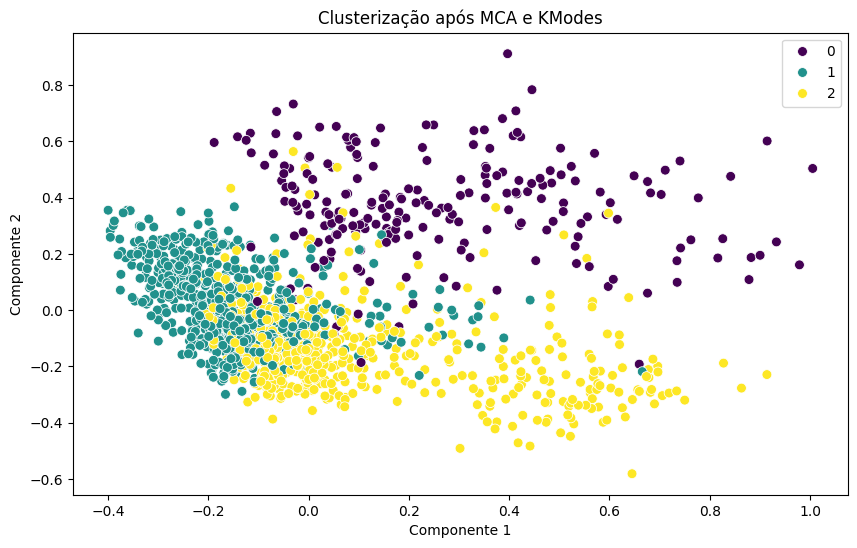

In [48]:
from kmodes.kmodes import KModes
from prince import MCA

# Transforme as colunas categóricas em numéricas usando MCA
mca = MCA(n_components=2)  # Defina o número de componentes principais desejado
df_mca = mca.fit_transform(df_cluster)

# Execute o KModes para clusterização
n_clusters = 3  # Número de clusters desejado
km = KModes(n_clusters=n_clusters, init='Huang', n_init=20, max_iter=100,random_state=2)
clusters_kmodes = km.fit_predict(df_cluster)  # Use o DataFrame original para o KModes

# Adicione o índice de cluster correspondente ao DataFrame após o MCA
df_kmodes = df_mca.copy()
mca_names = ['Componente 1', 'Componente 2']
df_kmodes.columns = mca_names
df_kmodes['Cluster'] = clusters_kmodes

# Função para visualização aprimorada dos clusters
def plotar_cluster_kmodes(df):
    plt.figure(figsize=(10, 6))

    # Escolha um mapa de cores de sua preferência
    colormap = 'viridis'

    # Plot dos clusters
    sns.scatterplot(data=df, x='Componente 1', y='Componente 2', hue='Cluster', palette=colormap, s=50)

    # Defina os rótulos dos eixos
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')

    # Defina o título do gráfico
    plt.title('Clusterização após MCA e KModes')

    # Mostrar a legenda
    plt.legend()

    # Mostrar o gráfico
    plt.show()

# Visualizar os clusters
plotar_cluster_kmodes(df_kmodes)


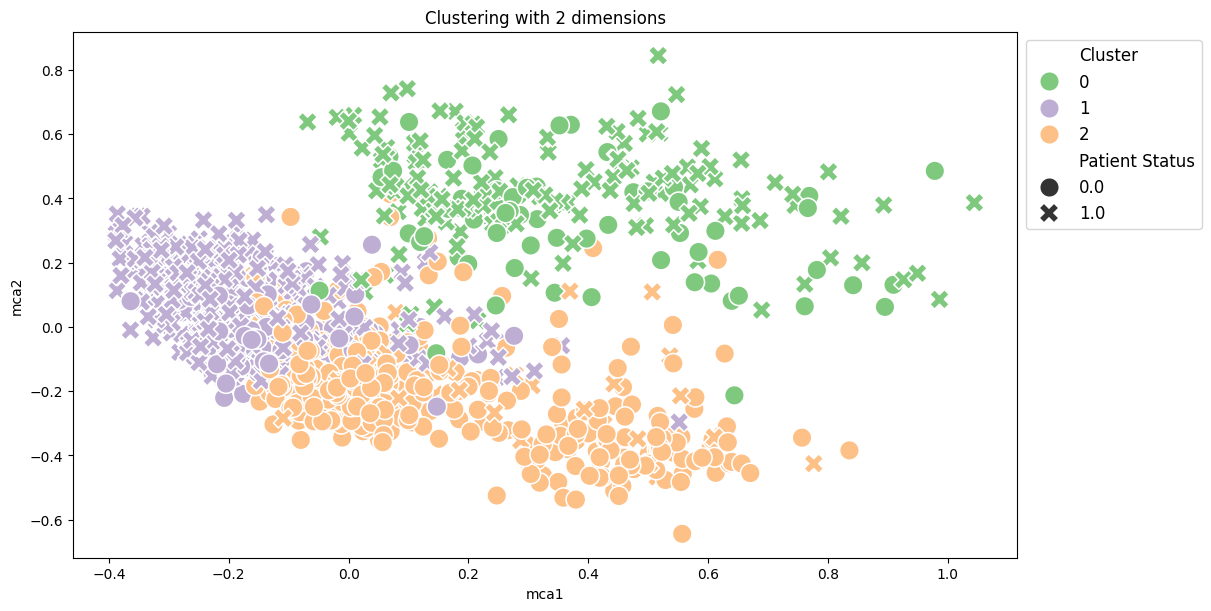

In [49]:
df_kmodes = df_cluster.copy()
df_kmodes['Cluster'] = clusters_kmodes
# Plotar gráfico dos clusters
plotar_cluster(clusters_kmodes, df_kmodes)

In [50]:
# Adiciona a coluna de cluster no dataframe inicial (sem one hot encode)
df_tuberculosis['Cluster'] = df_kmodes['Cluster']

In [51]:
df_tuberculosis['sexo'].value_counts()

# Primeiro, converta a coluna para string
df_tuberculosis['sexo'] = df_tuberculosis['sexo'].astype(str)

# Em seguida, transforme em tipo categórico
df_tuberculosis['sexo'] = df_tuberculosis['sexo'].astype('category')

In [52]:
# Cria um dataframe para cada cluster por meio de um filtro na coluna cluster do dataframe principal (df_tuberculosis)
df_cluster1 = df_tuberculosis.query('Cluster==0')
df_cluster2 = df_tuberculosis.query('Cluster==1')
df_cluster3 = df_tuberculosis.query('Cluster==2')

In [4]:
# Cluster1_report = ProfileReport(df_cluster1, minimal=True, title="Cluster 1")
# Cluster2_report = ProfileReport(df_cluster2, minimal=True, title="Cluster 2")
# Cluster3_report = ProfileReport(df_cluster3, minimal=True, title="Cluster 3")

# Faz o relatório de cada cluster utlizando o ProfileReport
Cluster1_report = ProfileReport(df_cluster1, title="Cluster 1")
Cluster2_report = ProfileReport(df_cluster2, title="Cluster 2")
Cluster3_report = ProfileReport(df_cluster3, title="Cluster 3")

In [3]:
from pandas_profiling import ProfileReport, compare
comparison_report = compare([Cluster1_report, Cluster2_report, Cluster3_report])

# Save report to file
# comparison_report.to_file("../EDA/Tuberculosis_Clusters_Comparison.html")

## Classificador de Resistência Medicamentosa

In [54]:
# Inclui a coluna de clusters
df_tuberculosis_normalized['Cluster'] = df_tuberculosis['Cluster']
df_tuberculosis_normalized.head(3)

C:\Users\Albert\AppData\Local\Temp\ipykernel_6888\3177285806.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tuberculosis_normalized['Cluster'] = df_tuberculosis['Cluster']


,Status_Resistencia,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,faixaEtaria_20_29,faixaEtaria_30_39,faixaEtaria_40_49,faixaEtaria_50_59,faixaEtaria_60_69,...,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB,Cluster
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,False,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,False,0


In [55]:
# Cria um dataframe para cada cluster por meio de um filtro na coluna cluster do dataframe principal (df_tuberculosis)
df_cluster1_normalized = df_tuberculosis_normalized.query('Cluster==0')
df_cluster2_normalized = df_tuberculosis_normalized.query('Cluster==1')
df_cluster3_normalized = df_tuberculosis_normalized.query('Cluster==2')

In [56]:
# Forma o conjunto de teste a partir de amostras de cada um dos clusters

feature_cluster_1= df_cluster1_normalized.drop(['Status_Resistencia', 'Cluster'], axis=1)
labels_cluster_1 =  df_cluster1_normalized['Status_Resistencia']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(feature_cluster_1, labels_cluster_1,test_size=0.1,stratify=labels_cluster_1, random_state=42)

feature_cluster_2= df_cluster2_normalized.drop(['Status_Resistencia', 'Cluster'], axis=1)
labels_cluster_2 =  df_cluster2_normalized['Status_Resistencia']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(feature_cluster_2, labels_cluster_2,test_size=0.1,stratify=labels_cluster_2, random_state=42)

feature_cluster_3= df_cluster3_normalized.drop(['Status_Resistencia', 'Cluster'], axis=1)
labels_cluster_3 =  df_cluster3_normalized['Status_Resistencia']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(feature_cluster_3, labels_cluster_3,test_size=0.1,stratify=labels_cluster_3, random_state=42)

In [57]:
labels_cluster_1.name

'Status_Resistencia'

In [58]:
features_names = feature_cluster_1.columns
label_name = labels_cluster_1.name

def create_dataframe(X, y, feature_names, label_name):
    # Criar o DataFrame df
    df = pd.concat([pd.DataFrame(X, columns=feature_names), pd.DataFrame(y, columns=[label_name])], axis=1)
    return df

df_test_1 = create_dataframe(X_test_1, y_test_1, features_names, label_name)
df_test_2 = create_dataframe(X_test_2, y_test_2, features_names, label_name)
df_test_3 = create_dataframe(X_test_3, y_test_3, features_names, label_name)



In [59]:
# Une as amostras de cada cluster

X_train = pd.concat([X_train_1, X_train_2, X_train_3], axis=0)
y_train = pd.concat([y_train_1, y_train_2, y_train_3], axis=0)

X_test = pd.concat([X_test_1, X_test_2, X_test_3], axis=0)
y_test = pd.concat([y_test_1, y_test_2, y_test_3], axis=0)

In [60]:
# features = df_tuberculosis_normalized.drop('Status_Resistencia', axis=1)
# labels = df_tuberculosis_normalized['Status_Resistencia']

# # Dividir os dados em treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### ReliefF

In [61]:
# from skrebate import ReliefF

# # Cria o objeto ReliefF
# relieff = ReliefF()

# # Aplica o ReliefF aos dados de treinamento e rótulos
# relieff.fit(X_train.values, y_train.values)

# # Obtém as pontuações de importância dos atributos
# importance_scores = relieff.feature_importances_

# # Cria um DataFrame com os atributos e suas pontuações de importância
# importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores})

# # Ordena o DataFrame em ordem decrescente de importância
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Exibe o DataFrame ordenado
# print("Importance Scores:")
# print(importance_df)

### Adaboost

[I 2023-08-25 12:16:51,452] A new study created in memory with name: no-name-d42b3261-f3bb-4076-b67c-465516dbb414
[I 2023-08-25 12:16:55,235] Trial 0 finished with value: 0.7980207916833267 and parameters: {'n_estimators': 132, 'learning_rate': 0.6726829641206514}. Best is trial 0 with value: 0.7980207916833267.
[I 2023-08-25 12:16:57,405] Trial 1 finished with value: 0.804578168732507 and parameters: {'n_estimators': 79, 'learning_rate': 0.2896427048081311}. Best is trial 1 with value: 0.804578168732507.
[I 2023-08-25 12:17:00,124] Trial 2 finished with value: 0.8135412501666 and parameters: {'n_estimators': 96, 'learning_rate': 0.02504244857252076}. Best is trial 2 with value: 0.8135412501666.
[I 2023-08-25 12:17:07,188] Trial 3 finished with value: 0.803745168599227 and parameters: {'n_estimators': 268, 'learning_rate': 0.16561553301695117}. Best is trial 2 with value: 0.8135412501666.
[I 2023-08-25 12:17:14,615] Trial 4 finished with value: 0.7980274556843929 and parameters: {'n_es

Resultados do modelo otimizado
[[115  34]
 [ 29 130]]
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       149
         1.0       0.79      0.82      0.80       159

    accuracy                           0.80       308
   macro avg       0.80      0.79      0.79       308
weighted avg       0.80      0.80      0.80       308



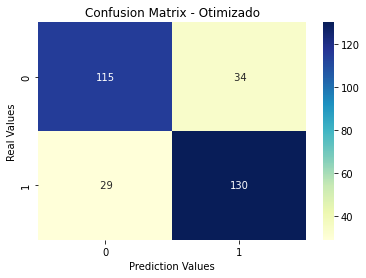

[MODELO ADABOOST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.44%
Média ROC-AUC: 0.87
Média F1-Score: 82.54%
Média Recall: 88.34%


ADABOOST - Feature Importance:
                                       Feature  Importance
68                                 cultEsc_Pos        0.19
55  descoberta_Elucidacao Diagn. em Internacao        0.12
66                            cultEsc_N/realiz        0.11
62                           BACOUTRO_N/realiz        0.10
59                                     bac_Neg        0.08
..                                         ...         ...
34                         tipoCaso_Retr Aband        0.00
31                               sitAtual_Cura        0.00
29               TIPOCUP_Profissional de Saude        0.00
28                               TIPOCUP_Outra        0.00
52       descoberta_Busca Ativa em Instituicao        0.00

[105 rows x 2 columns]


In [ ]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    
    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = AdaBoostClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_ada_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_ada_optimized))
print(classification_report(y_test, pred_ada_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_ada_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
adaboost_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
adaboost_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
adaboost_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
adaboost_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

adaboost_cross_accuracy = np.mean(adaboost_accuracy)
adaboost_cross_roc_auc = np.mean(adaboost_roc_auc)
adaboost_cross_f1 = np.mean(adaboost_f1)
adaboost_cross_recall = np.mean(adaboost_recall)

print('[MODELO ADABOOST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {adaboost_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {adaboost_cross_roc_auc:.2f}')
print(f'Média F1-Score: {adaboost_cross_f1*100:.2f}%')
print(f'Média Recall: {adaboost_cross_recall*100:.2f}%')

# Obter os valores de importância das features
adaboost_importances = best_model.feature_importances_

# Criar um DataFrame com as features e seus valores de importância
adaboost_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': adaboost_importances})

# Ordenar o DataFrame em ordem decrescente de importância
adaboost_feature_importance_df = adaboost_feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("ADABOOST - Feature Importance:")
print(adaboost_feature_importance_df)

### Random Forest

[I 2023-08-18 16:54:39,172] A new study created in memory with name: no-name-020b32d1-00d9-4931-ad16-35f6ef4bc767
[I 2023-08-18 16:54:43,228] Trial 0 finished with value: 0.8143409302945488 and parameters: {'n_estimators': 204, 'max_depth': 14}. Best is trial 0 with value: 0.8143409302945488.
[I 2023-08-18 16:54:46,972] Trial 1 finished with value: 0.8167932826869253 and parameters: {'n_estimators': 216, 'max_depth': 7}. Best is trial 1 with value: 0.8167932826869253.
[I 2023-08-18 16:54:51,123] Trial 2 finished with value: 0.8176062908170065 and parameters: {'n_estimators': 262, 'max_depth': 6}. Best is trial 2 with value: 0.8176062908170065.
[I 2023-08-18 16:54:53,061] Trial 3 finished with value: 0.8143475942956151 and parameters: {'n_estimators': 101, 'max_depth': 10}. Best is trial 2 with value: 0.8176062908170065.
[I 2023-08-18 16:54:57,645] Trial 4 finished with value: 0.8143542582966813 and parameters: {'n_estimators': 240, 'max_depth': 5}. Best is trial 2 with value: 0.8176062

Resultados do modelo otimizado
[[115  34]
 [ 28 131]]
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79       149
         1.0       0.79      0.82      0.81       159

    accuracy                           0.80       308
   macro avg       0.80      0.80      0.80       308
weighted avg       0.80      0.80      0.80       308



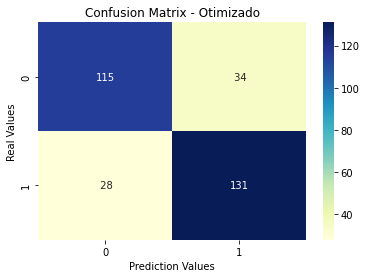

[MODELO RANDOM FOREST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.92%
Média ROC-AUC: 0.87
Média F1-Score: 83.18%
Média Recall: 89.98%


RANDOM FOREST - Feature Importance:
                Feature  Importance
68          cultEsc_Pos    0.287605
66     cultEsc_N/realiz    0.216999
67          cultEsc_Neg    0.040997
92          TABAGISMO_S    0.038407
91          TABAGISMO_N    0.037467
..                  ...         ...
74      NECROP_BAAR pos    0.000037
76  NECROP_Sugestivo TB    0.000000
37   FORMACLIN1_Genital    0.000000
42     FORMACLIN1_Ossea    0.000000
77              hiv_And    0.000000

[105 rows x 2 columns]


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_rf_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_rf_optimized))
print(classification_report(y_test, pred_rf_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_rf_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
rf_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
rf_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
rf_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
rf_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

rf_cross_accuracy = np.mean(rf_accuracy)
rf_cross_roc_auc = np.mean(rf_roc_auc)
rf_cross_f1 = np.mean(rf_f1)
rf_cross_recall = np.mean(rf_recall)

print('[MODELO RANDOM FOREST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {rf_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {rf_cross_roc_auc:.2f}')
print(f'Média F1-Score: {rf_cross_f1*100:.2f}%')
print(f'Média Recall: {rf_cross_recall*100:.2f}%')

# Obter os valores de importância das features
rf_importances = best_model.feature_importances_

# Criar um DataFrame com as features e seus valores de importância
rf_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances})

# Ordenar o DataFrame em ordem decrescente de importância
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("RANDOM FOREST - Feature Importance:")
print(rf_feature_importance_df)


### SVM

[I 2023-08-09 19:33:44,138] A new study created in memory with name: no-name-656f7e07-56cd-4fbc-8368-8ccc91b99c35


[I 2023-08-09 19:33:46,246] Trial 0 finished with value: 0.7926496068239371 and parameters: {'C': 6.308533144793601, 'kernel': 'poly'}. Best is trial 0 with value: 0.7926496068239371.
[I 2023-08-09 19:33:48,025] Trial 1 finished with value: 0.8342796214847393 and parameters: {'C': 0.7064416282014331, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:33:49,370] Trial 2 finished with value: 0.8285819005731042 and parameters: {'C': 0.015446480633540665, 'kernel': 'linear'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:33:50,798] Trial 3 finished with value: 0.8277622284419566 and parameters: {'C': 0.13348108534346687, 'kernel': 'linear'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:33:53,088] Trial 4 finished with value: 0.7852992136478741 and parameters: {'C': 22.704852616818105, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:34:04,636] Trial 5 finished with value: 0.822044515527

Resultados do modelo otimizado
[[122  33]
 [ 16 136]]
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       155
         1.0       0.80      0.89      0.85       152

    accuracy                           0.84       307
   macro avg       0.84      0.84      0.84       307
weighted avg       0.84      0.84      0.84       307



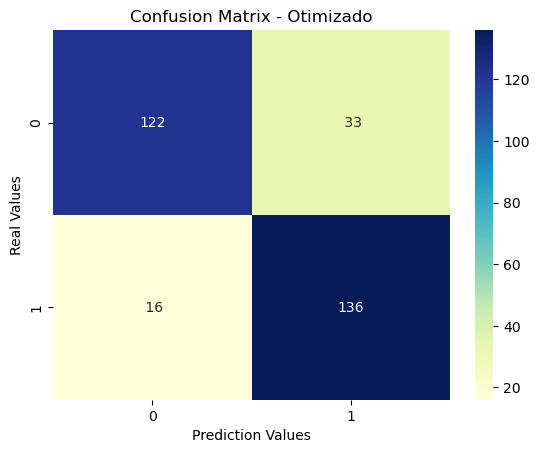

[MODELO SUPPORT VECTOR MACHINE] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 84.16%
Média ROC-AUC: 0.88
Média F1-Score: 84.96%
Média Recall: 89.25%


In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    model = SVC(
        C=C,
        kernel=kernel,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = SVC(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_svm_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_svm_optimized))
print(classification_report(y_test, pred_svm_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_svm_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
svm_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
svm_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
svm_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
svm_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

svm_cross_accuracy = np.mean(svm_accuracy)
svm_cross_roc_auc = np.mean(svm_roc_auc)
svm_cross_f1 = np.mean(svm_f1)
svm_cross_recall = np.mean(svm_recall)

print('[MODELO SUPPORT VECTOR MACHINE] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {svm_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {svm_cross_roc_auc:.2f}')
print(f'Média F1-Score: {svm_cross_f1*100:.2f}%')
print(f'Média Recall: {svm_cross_recall*100:.2f}%')

### XGboost

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'eta': trial.suggest_float('eta', 0.01, 1.0, log=True),
    }
    
    model = xgb.XGBClassifier(**params, random_state=42)

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_xgb_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_xgb_optimized))
print(classification_report(y_test, pred_xgb_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_xgb_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
xgb_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
xgb_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
xgb_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
xgb_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

xgb_cross_accuracy = np.mean(xgb_accuracy)
xgb_cross_roc_auc = np.mean(xgb_roc_auc)
xgb_cross_f1 = np.mean(xgb_f1)
xgb_cross_recall = np.mean(xgb_recall)

print('[MODELO XGBOOST] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {xgb_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {xgb_cross_roc_auc:.2f}')
print(f'Média F1-Score: {xgb_cross_f1*100:.2f}%')
print(f'Média Recall: {xgb_cross_recall*100:.2f}%')

# Obter os valores de importância das features
xgb_importances = best_model.feature_importances_

# Criar um DataFrame com as features e seus valores de importância
xgb_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})

# Ordenar o DataFrame em ordem decrescente de importância
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("XGBOOST - Feature Importance:")
print(xgb_feature_importance_df)

[I 2023-10-10 15:57:58,562] A new study created in memory with name: no-name-2bdb3147-edb4-45d1-a82d-f09e7382da04
[I 2023-10-10 15:58:02,423] Trial 0 finished with value: 0.8031175059952039 and parameters: {'booster': 'gbtree', 'lambda': 0.0004647812899531579, 'alpha': 4.100964123246441, 'eta': 0.057269402975748375}. Best is trial 0 with value: 0.8031175059952039.
[I 2023-10-10 15:58:06,451] Trial 1 finished with value: 0.7719841518089876 and parameters: {'booster': 'gbtree', 'lambda': 0.11794542075428999, 'alpha': 0.1724010572700988, 'eta': 0.21447099777542267}. Best is trial 0 with value: 0.8031175059952039.
[I 2023-10-10 15:58:17,596] Trial 2 finished with value: 0.764013137316234 and parameters: {'booster': 'dart', 'lambda': 0.016861825439925624, 'alpha': 0.00032495364117346345, 'eta': 0.15381507425473276}. Best is trial 0 with value: 0.8031175059952039.
[I 2023-10-10 15:58:18,893] Trial 3 finished with value: 0.815436346574914 and parameters: {'booster': 'gblinear', 'lambda': 0.05

KeyboardInterrupt: 

### Regressão logística

c:\Users\Albert\miniconda3\envs\tub\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-12 02:32:04,645] A new study created in memory with name: no-name-160799a6-5b00-4630-94cc-5862008541af
[I 2024-03-12 02:32:06,159] Trial 0 finished with value: 0.8125638619539153 and parameters: {'solver': 'saga', 'max_iter': 835, 'class_weight': 'balanced', 'C': 0.015280968812222708}. Best is trial 0 with value: 0.8125638619539153.
[I 2024-03-12 02:32:06,926] Trial 1 finished with value: 0.7973881764153894 and parameters: {'solver': 'liblinear', 'max_iter': 163, 'class_weight': 'balanced', 'C': 0.1072503949452399}. Best is trial 0 with value: 0.8125638619539153.
[I 2024-03-12 02:32:07,908] Trial 2 finished with value: 0.79666353873423 and parameters: {'solver': 'newton-cg', 'max_iter': 835, 'class_weight': None, 'C': 0.

Resultados do modelo otimizado
[[54 24]
 [11 66]]
              precision    recall  f1-score   support

         0.0       0.83      0.69      0.76        78
         1.0       0.73      0.86      0.79        77

    accuracy                           0.77       155
   macro avg       0.78      0.77      0.77       155
weighted avg       0.78      0.77      0.77       155



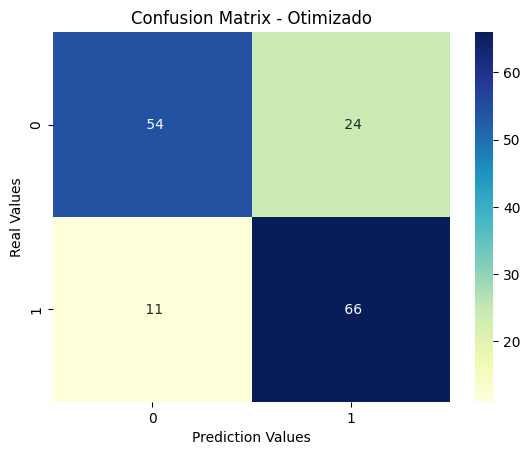

[MODELO REGRESSÃO LOGÍSTICA] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.40%
Média ROC-AUC: 0.85
Média F1-Score: 83.27%
Média Recall: 87.70%


REGRESSÃO LOGÍSTICA - Coeficientes das Features:
                                       Feature  Coefficient
63                                 cultEsc_Pos     0.930797
87                                 TABAGISMO_S     0.230724
50  descoberta_Elucidacao Diagn. em Internacao     0.203714
53                                bac_N/realiz     0.119946
45                                 classif_P+E     0.113682
..                                         ...          ...
57                           BACOUTRO_N/realiz    -0.176208
54                                     bac_Neg    -0.178283
86                                 TABAGISMO_N    -0.230711
62                                 cultEsc_Neg    -0.232174
61                            cultEsc_N/realiz    -0.689122

[100 rows x 2 columns]


In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    C = trial.suggest_float('C', 0.01, 10, log=True)
    
    model = LogisticRegression(
        solver=solver,
        max_iter=max_iter,
        class_weight=class_weight,
        C=C,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = LogisticRegression(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_lr_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_lr_optimized))
print(classification_report(y_test, pred_lr_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_lr_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
lr_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
lr_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
lr_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
lr_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

lr_cross_accuracy = np.mean(lr_accuracy)
lr_cross_roc_auc = np.mean(lr_roc_auc)
lr_cross_f1 = np.mean(lr_f1)
lr_cross_recall = np.mean(lr_recall)

print('[MODELO REGRESSÃO LOGÍSTICA] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {lr_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {lr_cross_roc_auc:.2f}')
print(f'Média F1-Score: {lr_cross_f1*100:.2f}%')
print(f'Média Recall: {lr_cross_recall*100:.2f}%')

# Obter os coeficientes das features da Regressão Logística
lr_coefficients = best_model.coef_[0]

# Criar um DataFrame com as features e seus coeficientes
lr_coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_coefficients})

# Ordenar o DataFrame pelos coeficientes em ordem decrescente
lr_coefficients_df = lr_coefficients_df.sort_values(by='Coefficient', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("REGRESSÃO LOGÍSTICA - Coeficientes das Features:")
print(lr_coefficients_df)


In [ ]:
# # Salvar modelo de regressão
# import pickle

# # Salvar o modelo
# with open('models/modelo_regressao_logistica.pkl', 'wb') as arquivo:
#     pickle.dump(best_model, arquivo)

In [63]:
import pickle
# Carregar o modelo
with open('models/modelo_regressao_logistica.pkl', 'rb') as arquivo:
    best_model = pickle.load(arquivo)

c:\Users\Albert\miniconda3\envs\tub\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Salvar os resultados dos modelos
* Os resultados são armazenados em uma tabela excel

In [ ]:
# Definir os dados das métricas para cada modelo
data = {
    'Modelo': ['Adaboost', 'Random Forest', 'SVM', 'XGBoost', 'Regressão Logística'],
    'Accuracy': [adaboost_cross_accuracy, rf_cross_accuracy, svm_cross_accuracy, xgb_cross_accuracy, lr_cross_accuracy],
    'ROC-AUC': [adaboost_cross_roc_auc, rf_cross_roc_auc, svm_cross_roc_auc, xgb_cross_roc_auc, lr_cross_roc_auc],
    'F1-Score': [adaboost_cross_f1, rf_cross_f1, svm_cross_f1, xgb_cross_f1, lr_cross_f1],
    'Recall': [adaboost_cross_recall, rf_cross_recall, svm_cross_recall, xgb_cross_recall, lr_cross_recall]
}

# Criar um DataFrame com os dados
df_metrics = pd.DataFrame(data)

# Definir o nome do arquivo Excel
excel_filename = '../Results/models_results.xlsx'

# Salvar o DataFrame no arquivo Excel
df_metrics.to_excel(excel_filename, index=False)

print(f"Arquivo '{excel_filename}' criado com sucesso!")

Arquivo '../Results/models_results.xlsx' criado com sucesso!


## Probabilidade de Apresentar Resistência Medicamentosa em cada Cluster

* Aplicar o modelo para prever a probabilidade em cada cluster

In [ ]:
# best_model.classes_

C:\Users\Albert\AppData\Local\Temp\ipykernel_6888\3013493892.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_combined, x='Cluster', y='Probabilidade', palette='Set2')


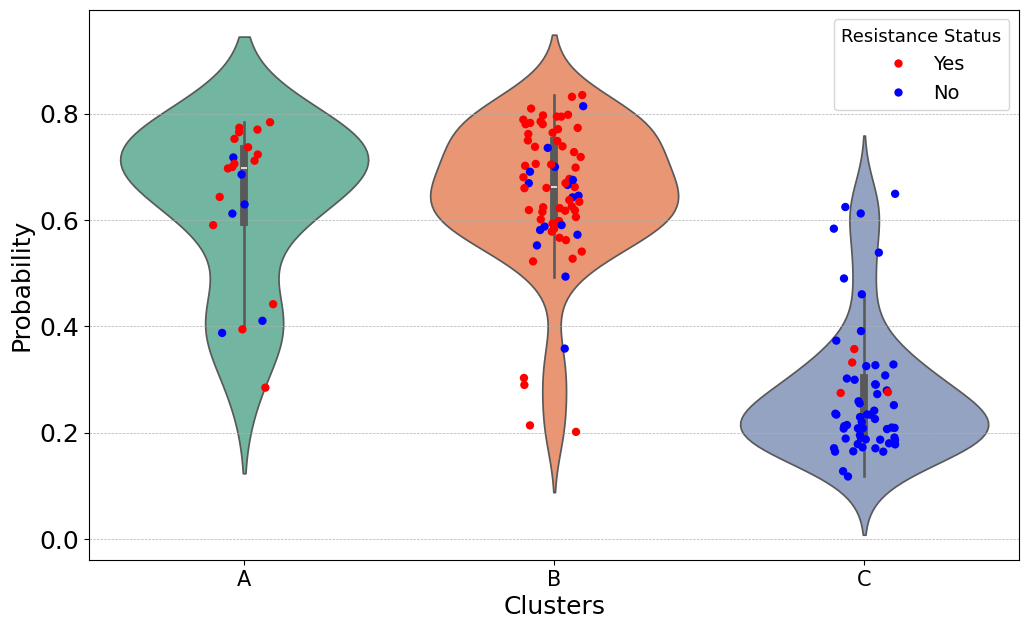

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

prob_1 = best_model.predict_proba(X_test_1)
prob_1 = prob_1[:, 1]

prob_2 = best_model.predict_proba(X_test_2)
prob_2 = prob_2[:, 1]

prob_3 = best_model.predict_proba(X_test_3)
prob_3 = prob_3[:, 1]

# # Função para remover outliers
# def remove_outliers(data):
#     Q1 = np.percentile(data, 25)
#     Q3 = np.percentile(data, 75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return data[(data >= lower_bound) & (data <= upper_bound)]

# # Remover outliers das variáveis
# prob_1 = remove_outliers(prob_1)
# prob_2 = remove_outliers(prob_2)
# prob_3 = remove_outliers(prob_3)

# Criar um DataFrame para cada vetor
df_prob_1 = pd.DataFrame({'Cluster': ['A'] * len(prob_1), 'Probabilidade': prob_1, 'Status_Resistencia': y_test_1})
df_prob_2 = pd.DataFrame({'Cluster': ['B'] * len(prob_2), 'Probabilidade': prob_2, 'Status_Resistencia': y_test_2})
df_prob_3 = pd.DataFrame({'Cluster': ['C'] * len(prob_3), 'Probabilidade': prob_3, 'Status_Resistencia': y_test_3})

# Concatenar os DataFrames
df_combined = pd.concat([df_prob_1, df_prob_2, df_prob_3], ignore_index=True)

# Converter os valores da coluna 'Status_Resistencia' para 'Yes' e 'No'
df_combined['Status_Resistencia'] = df_combined['Status_Resistencia'].map({1: 'Yes', 0: 'No'})

# Definir cores para os labels
palette_colors = {'Yes': 'red', 'No': 'blue'}

# Criar um gráfico de boxplot usando Seaborn
largura_figura = 12

plt.figure(figsize=(largura_figura, largura_figura/1.68))
ax = sns.violinplot(data=df_combined, x='Cluster', y='Probabilidade', palette='Set2')
sns.stripplot(data=df_combined, x='Cluster', y='Probabilidade', hue='Status_Resistencia', palette=palette_colors, size=6, ax=ax)

# plt.title('Probabilidades por Cluster')
plt.ylabel('Probability', fontsize=18)
plt.xlabel('Clusters', fontsize=18)


# Aumentar o tamanho dos eixos x e y
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
# Adicionar legenda e alterar o texto
# plt.legend(title='Status Resistência', fontsize=15)
# Adicionar a legenda abaixo do gráfico
# plt.legend(title='Resistance Status', fontsize=14, bbox_to_anchor=(0.5, -0.13), loc='upper center', title_fontsize='13')
plt.legend(title='Resistance Status', fontsize=14, loc='upper right', title_fontsize='13')

# Adicionar grid no eixo y
ax.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()